In [1]:
import pandas as pd

import sys
import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import norm

from prepare_aparent_data_helpers import *

import isolearn.io as isoio


In [2]:
#Load random+designed MPRA dataset

mpra_dict = isoio.load('prepared_data/apa_plasmid_data/apa_plasmid_data')


In [3]:

mpra_df = mpra_dict['plasmid_df']
mpra_cuts = mpra_dict['plasmid_cuts']


In [4]:

mpra_df['row_index'] = np.arange(len(mpra_df))


In [5]:
#Fix 1: Remove WHAMMP2 sublibrary

mpra_df = mpra_df.query("library_index != 35").copy().reset_index(drop=True)


In [6]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

array_df = seq_dict['array_df']


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626


In [7]:
#Keep human wildtype sequences only

filter_query = "variant == 'wt' and mean_total_count >= 200 and n_barcodes >= 7 and (experiment == 'clinvar_wt' or experiment == 'intronic_pas')"

array_df = array_df.query(filter_query).copy().reset_index(drop = True)

print("n (filtered) = " + str(len(array_df)))


n (filtered) = 10885


In [8]:
#Fix 2: Remove human variant sequences

mpra_df['master_seq'] = mpra_df['seq'].str.slice(20).str.slice(0, 164)
mpra_df = mpra_df.join(array_df[['master_seq', 'gene', 'experiment']].set_index('master_seq'), on='master_seq', how='left').copy().reset_index(drop=True)

mpra_df = mpra_df.loc[(mpra_df['library_index'] != 40) | (~mpra_df['gene'].isnull())].copy().reset_index(drop=True)


In [11]:
#Split human sequences into intronic PASes and wildtype ACMG/ClinVar

mpra_df.loc[(mpra_df['library_index'] == 40) & (mpra_df['experiment'] == 'clinvar_wt'), 'sublibrary_index'] = 41
mpra_df.loc[(mpra_df['library_index'] == 40) & (mpra_df['experiment'] == 'clinvar_wt'), 'sublibrary'] = 'clinvar_wt'

mpra_df.loc[(mpra_df['library_index'] == 40) & (mpra_df['experiment'] == 'intronic_pas'), 'sublibrary_index'] = 42
mpra_df.loc[(mpra_df['library_index'] == 40) & (mpra_df['experiment'] == 'intronic_pas'), 'sublibrary'] = 'intronic_pas'


In [13]:
#Remove corresponding rows in cut matrix

row_index = list(np.array(mpra_df['row_index'].values, dtype=np.int))
mpra_cuts = mpra_cuts[row_index, :]

#Clean up dataframe
mpra_df = mpra_df.drop(columns=['master_seq', 'row_index'])


In [14]:
#Dump fixed MPRA dataset

isoio.dump({'plasmid_df' : mpra_df, 'plasmid_cuts' : mpra_cuts}, 'prepared_data/apa_plasmid_data_v2/apa_plasmid_data_v2')


In [2]:
#Load random+designed MPRA dataset

mpra_dict = isoio.load('prepared_data/apa_plasmid_data_v2/apa_plasmid_data_v2')


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:

mpra_df = mpra_dict['plasmid_df']
mpra_cuts = mpra_dict['plasmid_cuts']


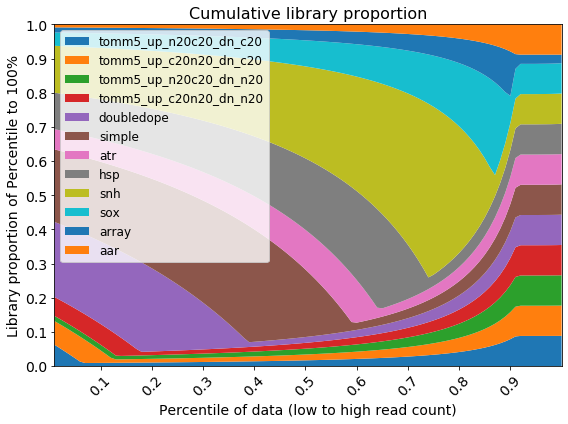

In [9]:
#Plot sublibrary cumulative proportions

plot_cumulative_library_proportion({'data' : mpra_df, 'cuts' : mpra_cuts}, percentile_step=0.01, figsize=(8, 6), n_xticks=10, n_yticks=10)


/home/jlinder2/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


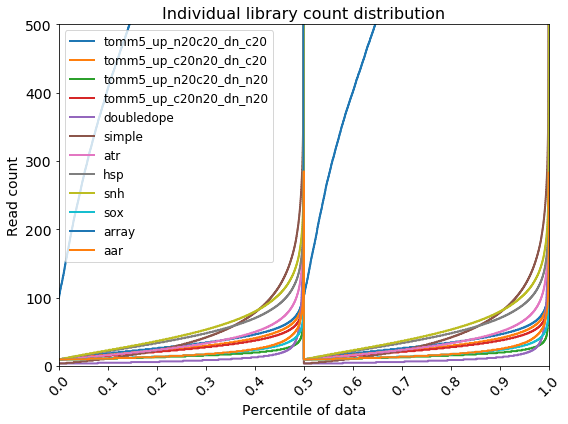

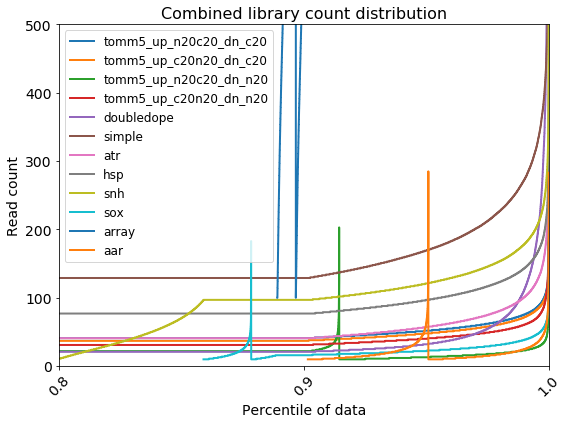

In [5]:
#Plot read count distribution over library

plot_individual_library_count_distribution({'data' : mpra_df, 'cuts' : mpra_cuts}, figsize=(8, 6), n_xticks=10, y_max=500)

plot_combined_library_count_distribution({'data' : mpra_df, 'cuts' : mpra_cuts}, figsize=(8, 6), n_xticks=10, x_min=0.8, x_max=1, y_max=500)
